In [1]:
%cd ../../FIA-MS/20200923_SoventTest_FIA-MS_metk/

/Users/matmat/Documents/FIA-MS/20200923_SoventTest_FIA-MS_metk


## Analysis on FIA-MS data after SmartPeak processing
#### This script is based on the assumption that mass ranges and pos/neg have already been merged. Triplicates will be taken care of by only keeping metabolites that were detected in all three of them.

#### Blanks have not fully been taken care of as of yet, they're just processed like regular runs

#### Imports (a bit excessive but did not weed out the important ones yet

In [2]:
import pymzml
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statistics
import csv
import pickle
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import copy

import matplotlib.colors
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from mpl_toolkits.mplot3d import Axes3D

from pandas.errors import EmptyDataError

import seaborn as sns
from collections import defaultdict

import xml.etree.ElementTree as ET

from pyopenms import *


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## Process HMDB entries from file

In [3]:
HMDB2StructMapping = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200923_SoventTest_FIA-MS_metk/CHEMISTRY/HMDB2StructMapping.tsv", 
                                 sep="\t", header=None)

In [4]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200923_SoventTest_FIA-MS_metk/traML.csv", 
                                 sep="\,", header=None, engine='python')
SerumTop10 = list(SerumTop10.iloc[:,0])[1:]

# Functions

In [5]:
def extract_names_and_intensity(path_to_featureXML_dir, database_name_array):
    wd = path_to_featureXML_dir
    
    filenames_list = []
    for (dirpath, dirnames, filenames) in os.walk(wd):
        filenames_list.extend(filenames)
        break
    sorted_filenames_list = sorted(filenames_list)
    
    timestep_alldata = {}
    for file in sorted_filenames_list:
        features = FeatureMap()
        FeatureXMLFile().load(wd + "/" + file, features)
        extracted_data = {}
        for f in features:
            if f.getMetaValue("PeptideRef").decode("utf-8") in database_name_array:
                extracted_data[f.getMetaValue("PeptideRef").decode("utf-8")] = (f.getMetaValue("peak_apex_int"))
        extracted_data_df = pd.DataFrame(extracted_data.items(), columns=['Metabolite', 'Intensity'])
        timestep_alldata[file] = extracted_data_df
    
    return timestep_alldata

In [6]:
def calculate_mean_and_variance(extracted_info, txt_output_name):
    stats_of_files = {}
    for file_n in range(0, len(extracted_info), 3):
        stats_of_compound = pd.DataFrame(columns = ['Metabolite', 'Mean', 'Variance'])
        file = list(extracted_info.items())
        for metabolite_n in range(0, len(file[file_n][1])):
            if file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 1][1]['Metabolite']) and \
            file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 2][1]['Metabolite']):
                file_1 = file[file_n][1]
                file_2 = file[file_n + 1][1]
                file_3 =  file[file_n + 2][1]

                index_2 = list(file_2['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                index_3 = list(file_3['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                mean_of_compound = statistics.mean([file_1['Intensity'][metabolite_n],\
                                                  file_2['Intensity'][index_2],\
                                                  file_3['Intensity'][index_3]])
                variance_of_compound = statistics.variance([file_1['Intensity'][metabolite_n],\
                                                           file_2['Intensity'][index_2],\
                                                           file_3['Intensity'][index_3]])
                stats = pd.DataFrame([[file_1['Metabolite'][metabolite_n], mean_of_compound, variance_of_compound]],\
                                    columns = ['Metabolite', 'Mean', 'Variance'])
                stats_of_compound = stats_of_compound.append(stats, ignore_index = True)
        stats_of_files[file[file_n][0][:-13]] = stats_of_compound
        
    with open(txt_output_name, 'wb') as handle:
        pickle.dump(stats_of_files, handle)
    #return stats_of_files

## Define working directory

In [7]:
wd = "/Users/matmat/Documents/FIA-MS/20200923_SoventTest_FIA-MS_metk/"

## Process samples compared to the full HMDataBase (this will take a while)

In [10]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_30sec", HMDB2StructMapping[0].unique()), wd + "features_30sec.txt")

In [11]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_60sec", HMDB2StructMapping[0].unique()), wd + "features_60sec.txt")

In [12]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_90sec", HMDB2StructMapping[0].unique()), wd + "features_90sec.txt")

## Process samples compare to the top 10 serum metabolites

In [13]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_30sec", np.array(SerumTop10, dtype = object)), wd + "SerumTop10_30sec.txt")

In [14]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_60sec", np.array(SerumTop10, dtype = object)), wd + "SerumTop10_60sec.txt")

In [15]:
calculate_mean_and_variance(
    extract_names_and_intensity(
        wd + "features_90sec", np.array(SerumTop10, dtype = object)), wd + "SerumTop10_90sec.txt")

# Import generated data
#### This step is separate in order to be able to jump back in without having to process everything again

In [8]:
with open(wd + "features_30sec.txt", 'rb') as handle:
    features_30sec = pickle.loads(handle.read())
with open(wd + "features_60sec.txt", 'rb') as handle:
    features_60sec = pickle.loads(handle.read())
with open(wd + "features_90sec.txt", 'rb') as handle:
    features_90sec = pickle.loads(handle.read())

In [9]:
with open(wd + "SerumTop10_30sec.txt", 'rb') as handle:
    SerumTop10_30sec = pickle.loads(handle.read())
with open(wd + "SerumTop10_60sec.txt", 'rb') as handle:
    SerumTop10_60sec = pickle.loads(handle.read())
with open(wd + "SerumTop10_90sec.txt", 'rb') as handle:
    SerumTop10_90sec = pickle.loads(handle.read())

#### Group files (select which wants you want to plot)

In [10]:
stats_files = [features_30sec, features_60sec, features_90sec] 

In [20]:
stats_files = [SerumTop10_30sec, SerumTop10_60sec, SerumTop10_90sec] 

#### This step is optional, I added it when I had everything in one folder. In general, it is advised to put the processed files into a different folder than the "raw" data

In [21]:
collection = []
i = 0
for files in stats_files:
    new_dict = {}
    for keys in files.keys():
        if '1900-01-01_0000' not in keys:
            new_dict[keys] = stats_files[i][keys]
    collection.append(new_dict)
    i += 1
stats_files = collection

In [22]:
for file in stats_files:
    for each in file:
        file[each]['Rel_Stdv'] = np.sqrt(file[each]['Variance'])/file[each]['Mean']

In [17]:
"""from tabulate import tabulate

file_names = ['features_30sec', 'features_60sec', 'features_90sec', 'features_180sec'] 
j = 0
for file in stats_files:
    for i in file:
        print(tabulate(file[i], headers='keys'))
    j += 1"""

Metabolite    Mean    Variance    Rel_Stdv
------------  ------  ----------  ----------
Metabolite    Mean    Variance    Rel_Stdv
------------  ------  ----------  ----------
    Metabolite          Mean     Variance    Rel_Stdv
--  ----------------  ------  -----------  ----------
 0  HMDB:HMDB0000122  183801  2.32818e+08   0.0830157
 1  HMDB:HMDB0000641  116919  5.17576e+08   0.194582
    Metabolite                    Mean     Variance    Rel_Stdv
--  ----------------  ----------------  -----------  ----------
 0  HMDB:HMDB0000122  345518            1.95375e+10    0.404543
 1  HMDB:HMDB0000182       2.54143e+06  3.57739e+12    0.744228
 2  HMDB:HMDB0000641       2.60534e+06  6.39798e+12    0.97086
    Metabolite          Mean     Variance    Rel_Stdv
--  ----------------  ------  -----------  ----------
 0  HMDB:HMDB0000122  164795  2.28481e+09    0.290055
    Metabolite                    Mean     Variance    Rel_Stdv
--  ----------------  ----------------  -----------  ----------


In [18]:
"""import fpdf

pdf = fpdf.FPDF(format='letter')
pdf.add_page()
pdf.set_font("Arial", size=12)

file_names = ['SerumTop10_30sec', 'SerumTop10_60sec', 'SerumTop10_90sec', 'SerumTop10_180sec'] 
#file_names = ['features_30sec', 'features_60sec', 'features_90sec', 'features_180sec'] 

j = 0
for file in stats_files:
    pdf.write(5,str(file_names[j]))
    pdf.ln()
    for i in file:
        pdf.write(5,str(i))
        pdf.ln()
        pdf.write(5,tabulate(file[i], headers='keys'))
        pdf.ln()
    pdf.output(str(file_names[j]) + ".pdf")
    j += 1"""

'import fpdf\n\npdf = fpdf.FPDF(format=\'letter\')\npdf.add_page()\npdf.set_font("Arial", size=12)\n\nfile_names = [\'SerumTop10_30sec\', \'SerumTop10_60sec\', \'SerumTop10_90sec\', \'SerumTop10_180sec\'] \n#file_names = [\'features_30sec\', \'features_60sec\', \'features_90sec\', \'features_180sec\'] \n\nj = 0\nfor file in stats_files:\n    pdf.write(5,str(file_names[j]))\n    pdf.ln()\n    for i in file:\n        pdf.write(5,str(i))\n        pdf.ln()\n        pdf.write(5,tabulate(file[i], headers=\'keys\'))\n        pdf.ln()\n    pdf.output(str(file_names[j]) + ".pdf")\n    j += 1'

#### Define parameters depending on what has been done and the naming convention

In [23]:
sample_types = ['Blank', 'QCSerum']
# settings = ['NewSourceSettings', 'OldSourceSettings']
solvents = ['AcN_Water_5mMAC_pH9', 'AcN_Water_5mMAF_pH3', 'AcN_Water_FA', 
            'IPA_Water_5mMAC_pH9', 'IPA_Water_5mMAF_pH3', 'MeOH_Water_FA']
#methods = ['LH', 'M_0_2sWaste', 'M_0_4sWaste', 'M', 'M_HighInjSpeed_0_2sWaste',
#          'M_HighInjSpeed_0_4sWaste', 'M_HighInjSpeed']
charges = ['POS', 'NEG']
#masses = ['HighMass', 'LowMass']
times = [30, 60, 90]
dates = ['20200923']
file_names = ['30sec', '60sec', '90sec']

## Plotting. Make sure that the naming convention is also applicable here
#### If you want to export the plots, uncomment the last line and adjust the name

In [24]:
x = stats_files[0]['Blank_AcN_Water_5mMAC_pH9_NEG'].iloc[:,0]

In [25]:
y = stats_files[0]['Blank_AcN_Water_5mMAC_pH9_POS'].iloc[:,0]

In [26]:
len(set().union(x, y))

6

Blank
POS
6
6
6
2
5
6
2
5
5
5
6
6
6
6
6
5
6
6
6
NEG
6


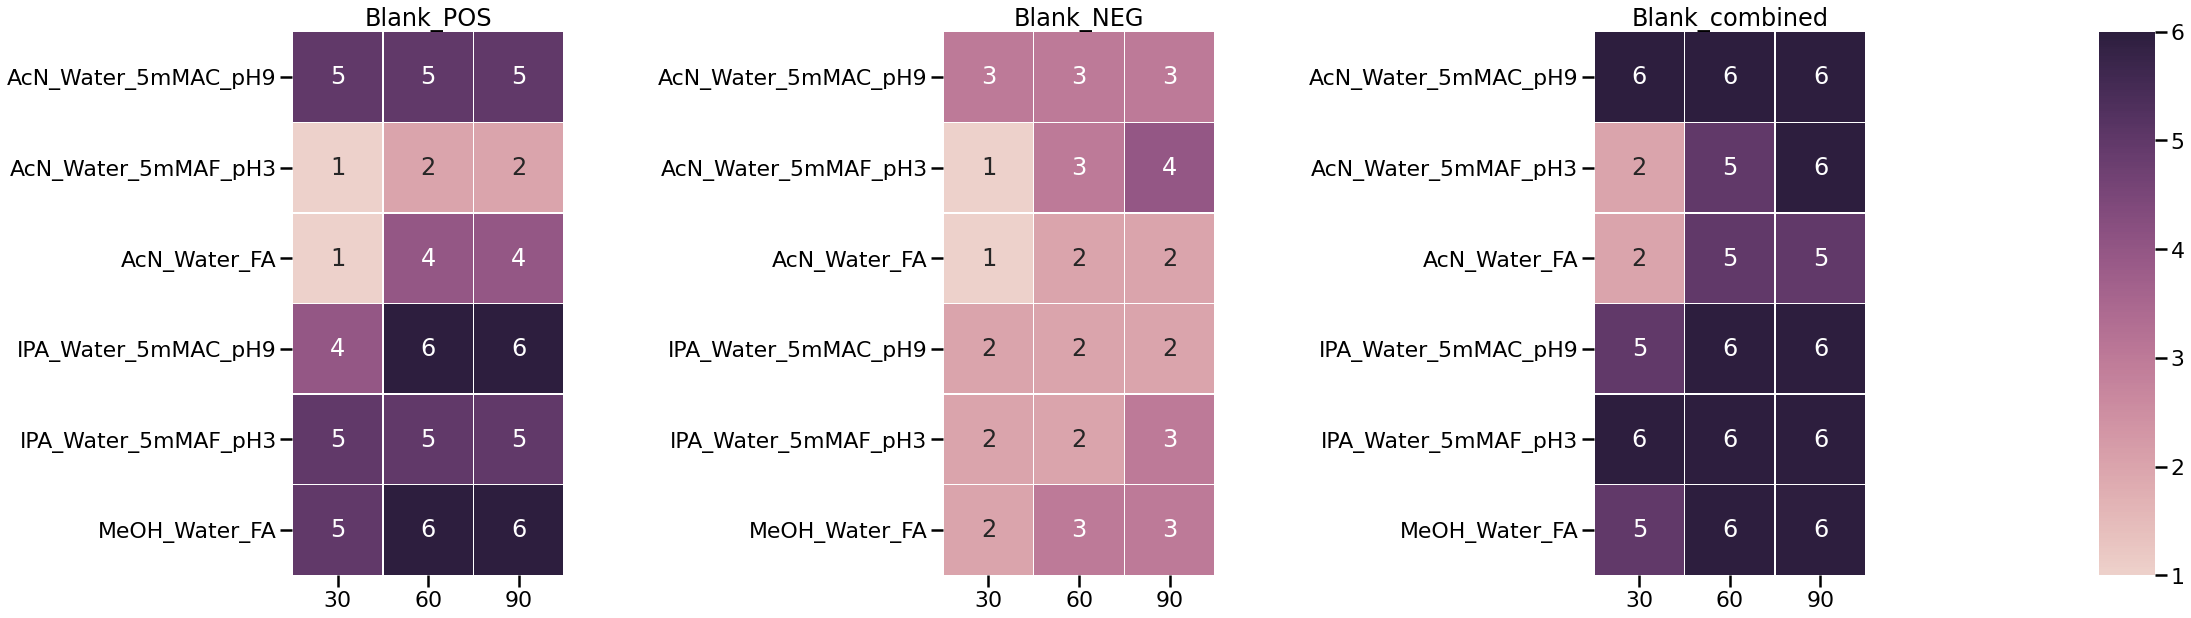

QCSerum
POS
7
7
7
7
7
7
6
7
7
7
8
8
7
7
7
6
7
7
8
NEG
8


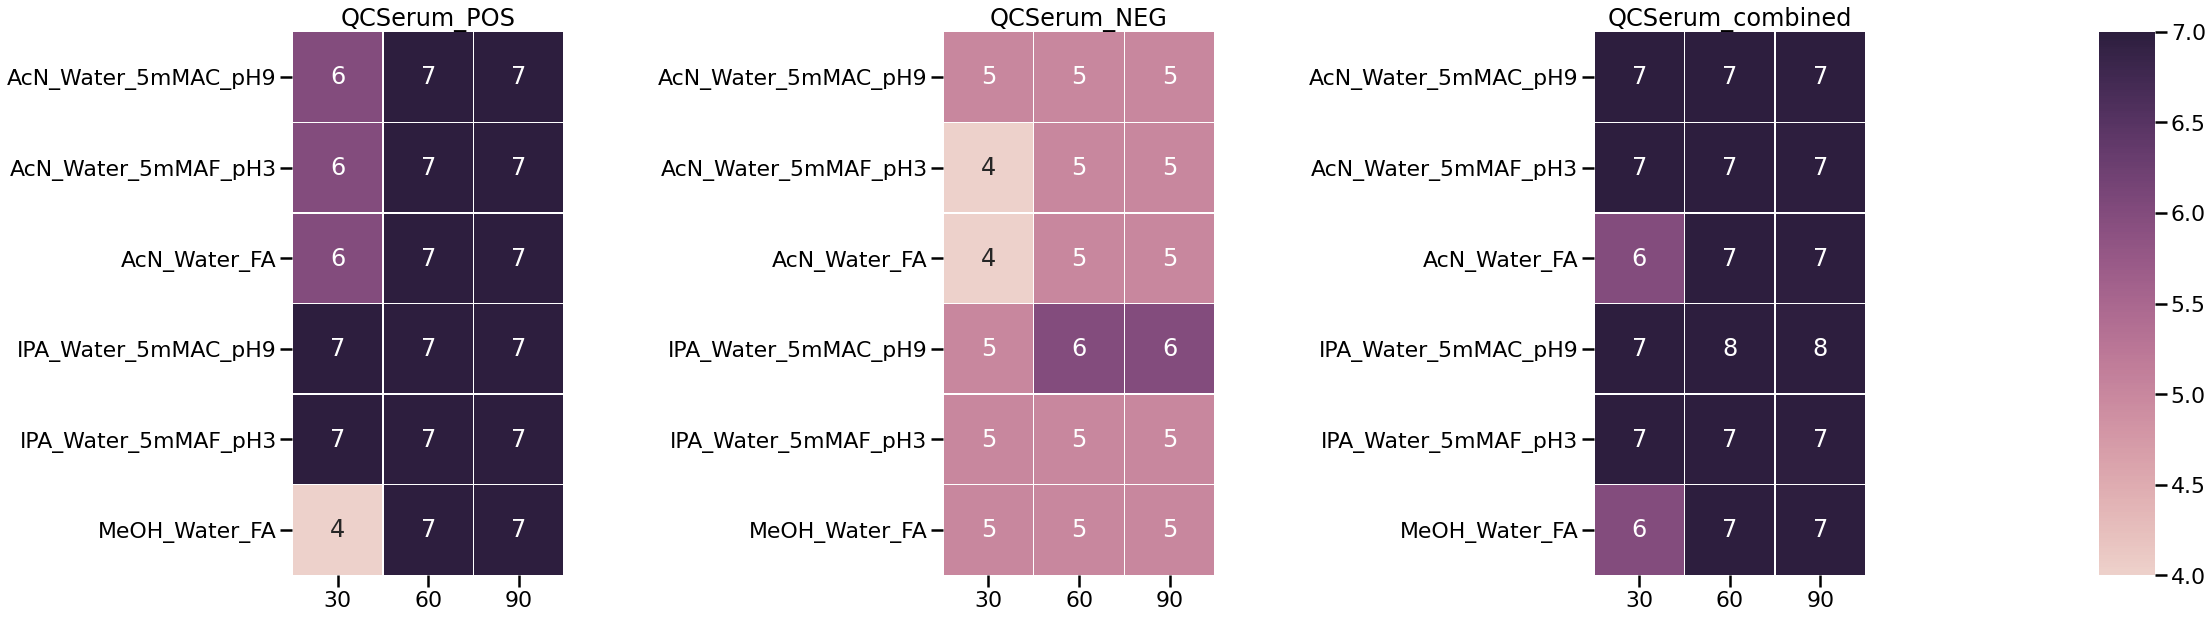

In [27]:
for sample_type in sample_types:
    print(sample_type)
    sns.set_context("poster")
    f, axs = plt.subplots(1, 3 + 1, figsize=(12*3, 10), gridspec_kw={'width_ratios': [5]*3 + [0.5]})
    cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
    i = 0
    df_heat_combined = pd.DataFrame(index=solvents, columns=times)
    for charge in charges:
        print(charge)
        df_heat = pd.DataFrame(index=solvents, columns=times)
        for solvent in solvents:
            j = 0
            for file in stats_files:
                a = sample_type + '_' + solvent + '_' + charge
                df_heat.loc[solvent, times[j]] = len(file[a])
                if charge == 'POS':
                    b = sample_type + '_' + solvent + '_NEG'
                    c = set(file[a].iloc[:,0])
                    d = set(file[b].iloc[:,0])
                    df_heat_combined.loc[solvent, times[j]] = len(set().union(c, d))
                    print(df_heat_combined.loc[solvent, times[j]])
                j += 1
        df_heat = df_heat.astype(int)
        df_heat_combined2 = df_heat_combined.astype(int)
        print(df_heat_combined2.max().max())
        if charge == 'POS':
            p_max = df_heat.max().max()
            p_min = df_heat.min().min() 
        sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=p_max, vmin=p_min,
            square=True, linewidths=.5, cbar=(charge=='POS'), cbar_ax=axs[-1], ax=axs[i])
        axs[i].set_ylim(len(solvents), 0)
        axs[i].set_title(sample_type + '_' + charge)
        i += 1
        if charge == 'POS':
            sns.heatmap(df_heat_combined2, annot=True, fmt="d", cmap=cmap, vmax=p_max, vmin=p_min,
                square=True, linewidths=.5, cbar=(charge=='POS'), cbar_ax=axs[-1], ax=axs[i+1])
            axs[i+1].set_ylim(len(solvents), 0)
            axs[i+1].set_title(sample_type + '_' + 'combined')
    plt.show()
    f.savefig(dates[0] + '_' + 'SerumTop10' + '_' + sample_type + '.pdf')

In [75]:
"""
for sample_type in sample_types:
    print(sample_type)
    for charge in charges:
        print(charge)
        sns.set_context("poster")
        f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={'width_ratios': [10]*len(solvents) + [0.5]})
        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
        i = 0
        for solvent in solvents:
            df_heat = pd.DataFrame(index=methods + ['OldSourceSettings_LH'], columns=times)
            for method in methods:
                for setting in settings:
                    if setting == 'NewSourceSettings':
                        j = 0
                        for file in stats_files:
                            a = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                            df_heat.loc[method, times[j]] = len(file[a])
                            j += 1
                    else:
                        j = 0
                        for file in stats_files:
                            b = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + methods[0] + '_' + charge
                            df_heat.loc[(methods + ['OldSourceSettings_LH'])[len((methods + ['OldSourceSettings_LH'])) - 1], times[j]] = len(file[b])
                            j += 1
            df_heat = df_heat.astype(int)
            sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=df_heat.max().max(), vmin=df_heat.min().min(),
                square=True, linewidths=.5, cbar=(solvent=='20water_60MeOH'), cbar_ax=axs[-1], ax=axs[i])
            axs[i].set_ylim(len(methods + ['OldSourceSettings_LH']), 0)
            axs[i].set_title(f'{solvent}')
            i += 1
        plt.show()
        #f.savefig('FullDB' + '_' + sample_type + '_' + charge + '.pdf')
        """

'\nfor sample_type in sample_types:\n    print(sample_type)\n    for charge in charges:\n        print(charge)\n        sns.set_context("poster")\n        f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={\'width_ratios\': [10]*len(solvents) + [0.5]})\n        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)\n        i = 0\n        for solvent in solvents:\n            df_heat = pd.DataFrame(index=methods + [\'OldSourceSettings_LH\'], columns=times)\n            for method in methods:\n                for setting in settings:\n                    if setting == \'NewSourceSettings\':\n                        j = 0\n                        for file in stats_files:\n                            a = dates[0] + \'_\' + sample_type + \'_\' + setting + \'_\' + solvent + \'_\' + method + \'_\' + charge\n                            df_heat.loc[method, times[j]] = len(file[a])\n                            j += 1\n                    else:\n   

## Violin plots (they will produce a lot of plots)

#### Solvent overview

In [16]:
stats_files2 = copy.deepcopy(stats_files)
for file in stats_files2:
    for each in file:
        file[each]['Run'] = each
        file[each]['Group'] = None

Blank
NEG
AcN_Water_5mMAC_pH9
AcN_Water_5mMAF_pH3
AcN_Water_FA
IPA_Water_5mMAC_pH9
IPA_Water_5mMAF_pH3
MeOH_Water_FA


KeyboardInterrupt: 

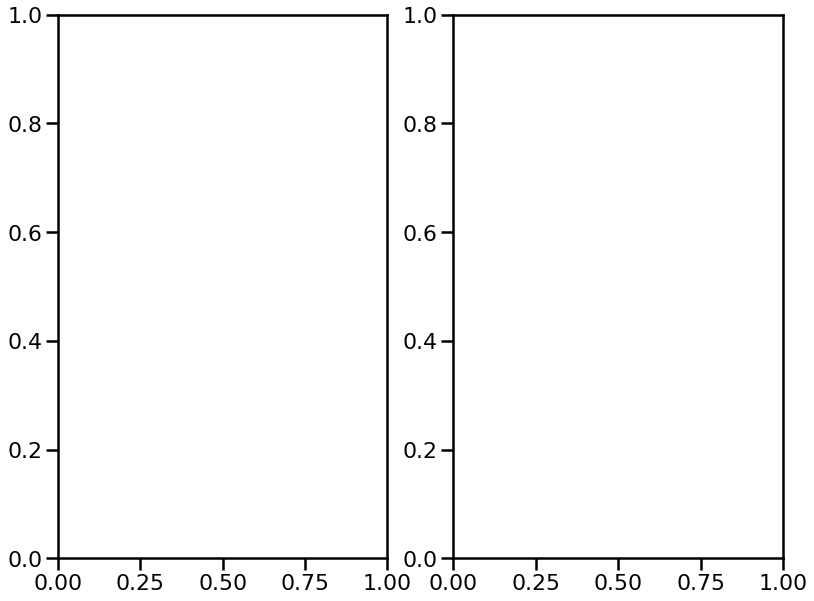

In [17]:
param = 'Mean'#'Rel_Stdv' # 'Mean'

file_counter = 0
for file in stats_files2:
    for sample_type in sample_types:
        print(sample_type)
        print(charge)
        sns.set_context("poster")
        f, axs = plt.subplots(1, len(charges), figsize=(13, 10), gridspec_kw={'width_ratios': [8] * 2})
        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
        i = 0
        for charge in charges:
            results_collection = []
            sum_file = pd.concat(file)
            names_collection = []
            for solvent in solvents:
                for name in list(sum_file.index):
                    names_collection.append(name[0])
                    run_name = sample_type + '_' + solvent + '_' + charge
                    abbrv_name = solvent + '_' + charge
                    if run_name in names_collection:
                        run_data = copy.deepcopy(sum_file.loc[run_name,:])
                        run_data.loc[:,'Run'] = abbrv_name
                        results_collection.append(run_data)
                print(solvent)
            results_collection = pd.concat(results_collection)
            axs[i].set_title((file_names[file_counter] + '_' + sample_type + '_' + charge), fontweight="bold", size=20, y=1.08) # Title
            sns.set_style("whitegrid")
            sns.violinplot(x="Run", y=param, data=results_collection, orient = 'v', linewidth=2, ax=axs[i],
                          cmap=cmap)
            axs[i].tick_params('x', labelrotation=90, labelsize = 15)
            axs[i].tick_params('y', labelrotation=0, labelsize = 15)
            axs[i].set_xlabel('Runs', fontsize=15)
            axs[i].set_ylabel(param, fontsize=15)
            plt.tight_layout()
            i += 1
        
        plt.show()
        f.savefig('Full_' + param + '_' + file_names[file_counter] + '_' + sample_type + '_' + charge + '.pdf')
    file_counter += 1

#### Single metabolite (use with serum top 10 files)

In [49]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/traML.csv", 
                                 sep="\,", header=None, engine='python')
DB = list(SerumTop10.iloc[:,0])[1:]
Name = list(SerumTop10.iloc[:,3])[1:]
trans = {'DB': DB, 'Name': Name}

translator = pd.DataFrame(trans)

Blank


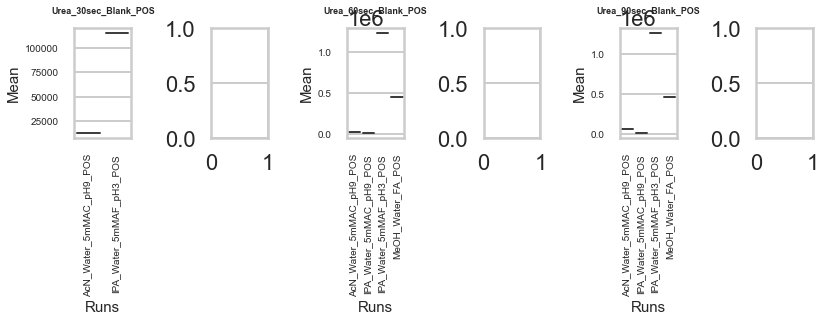

QCSerum


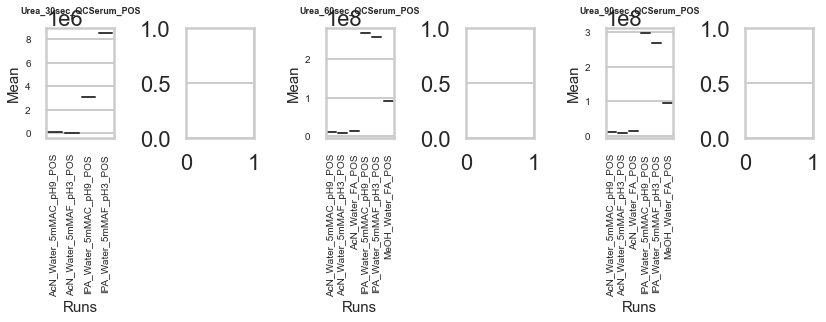

Blank


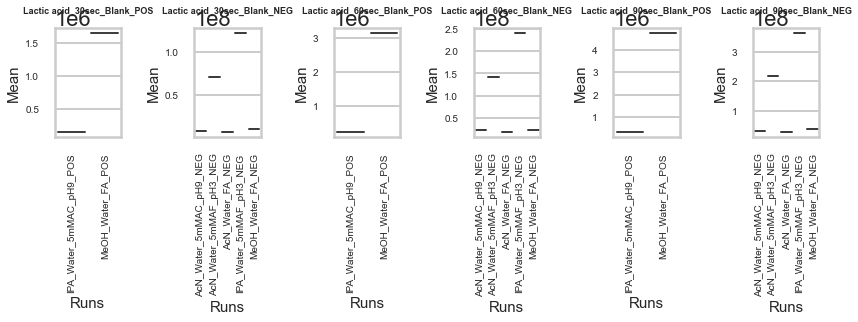

QCSerum


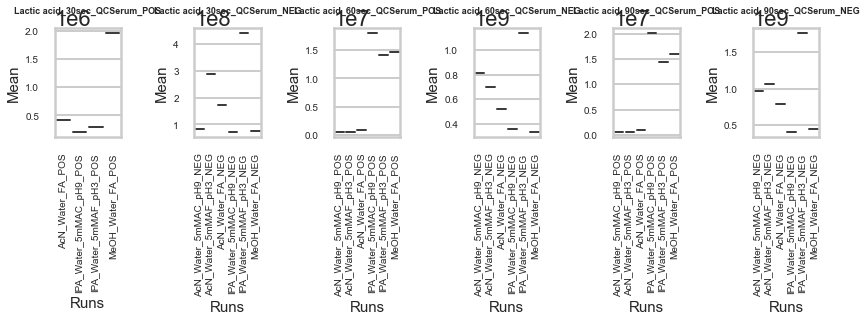

Blank


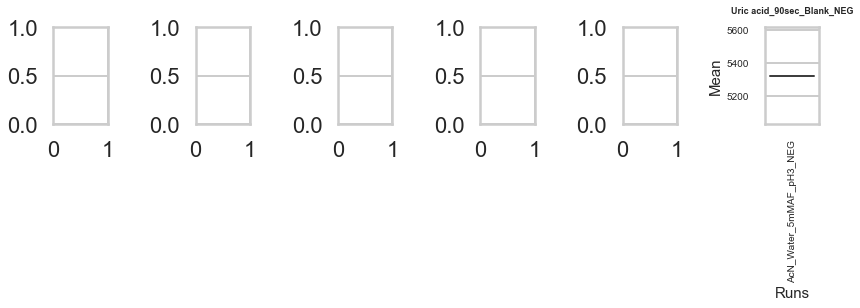

QCSerum


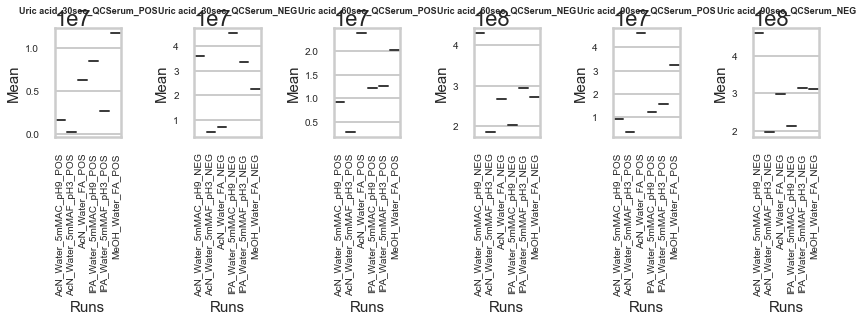

Blank


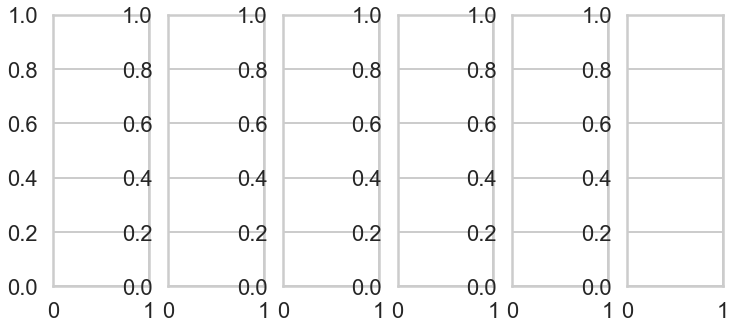

QCSerum


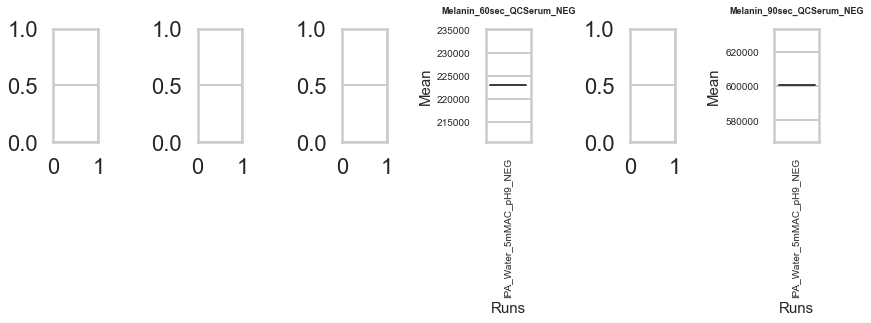

Blank


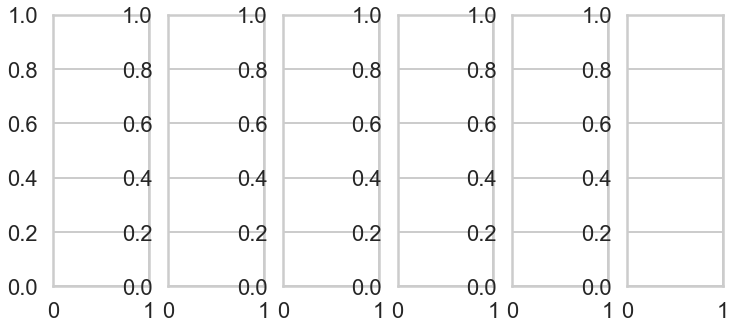

QCSerum


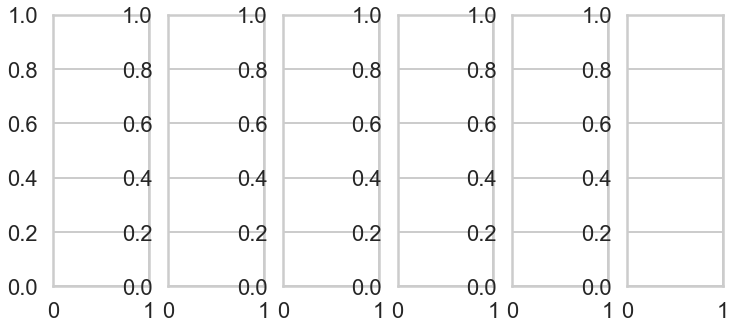

Blank


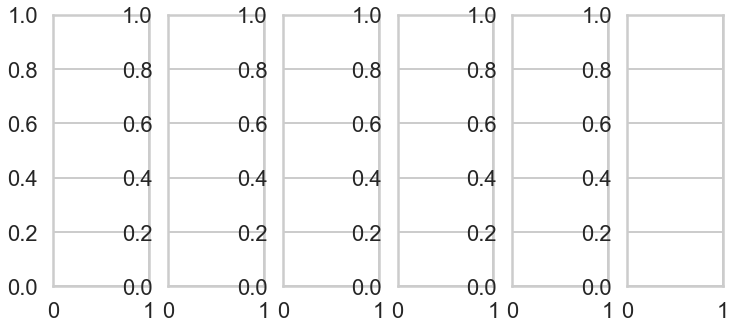

QCSerum


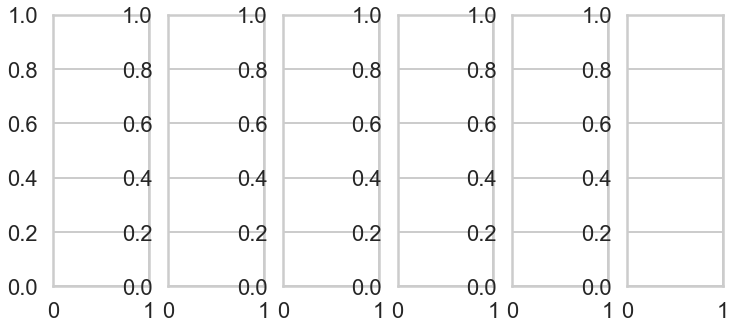

Blank


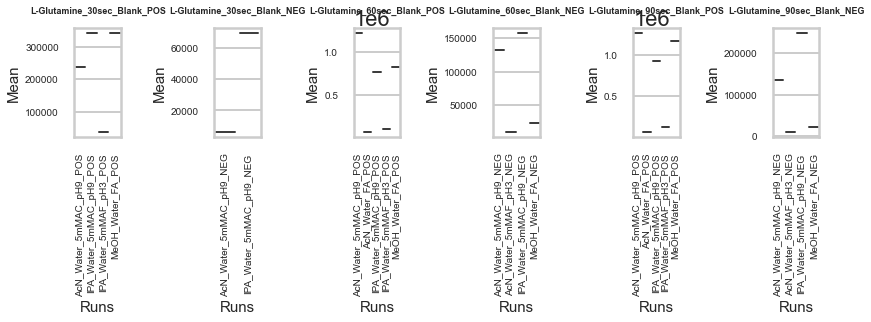

QCSerum


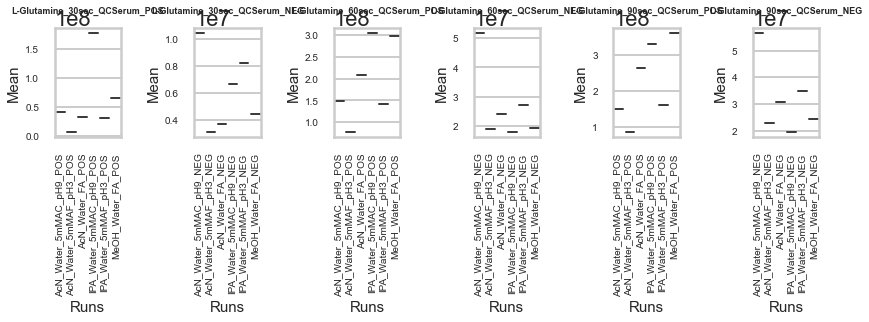

Blank


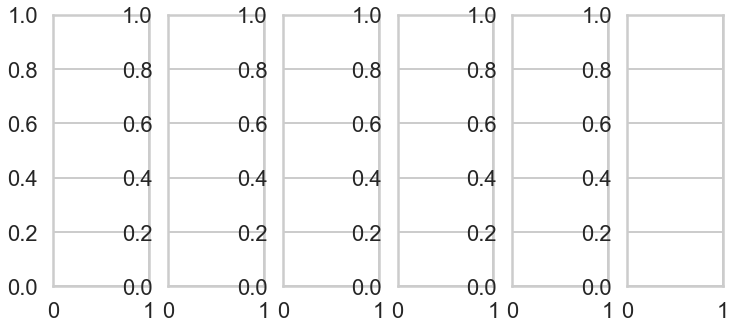

QCSerum


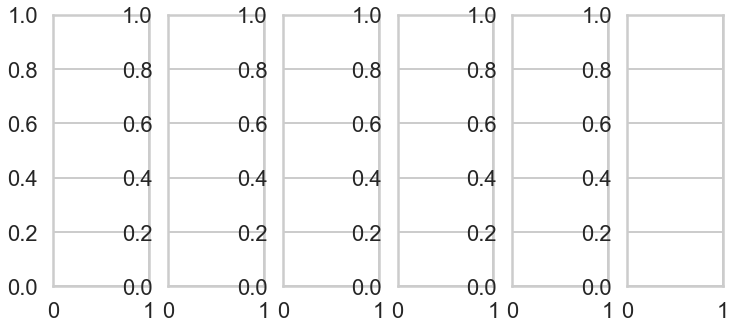

Blank


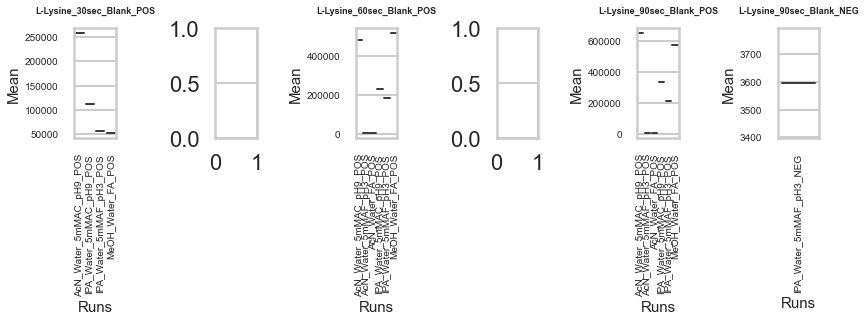

QCSerum


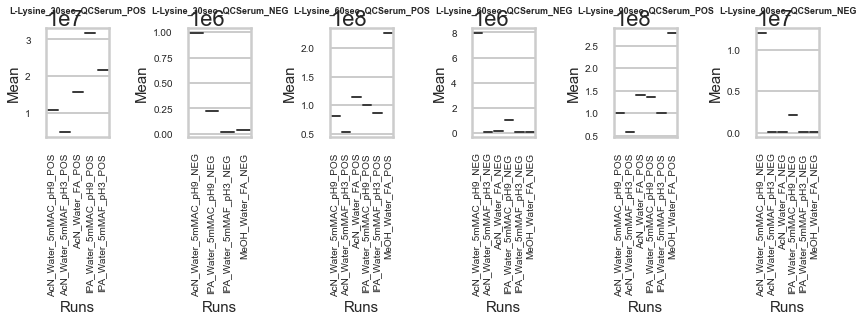

Blank


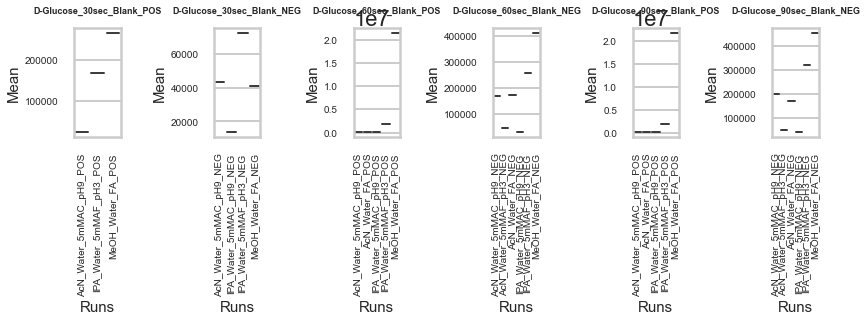

QCSerum


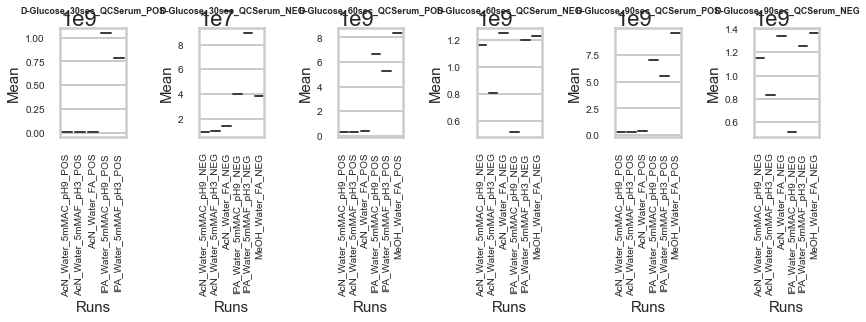

Blank


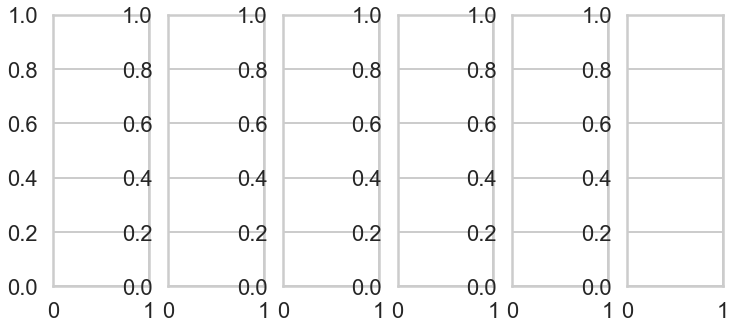

QCSerum


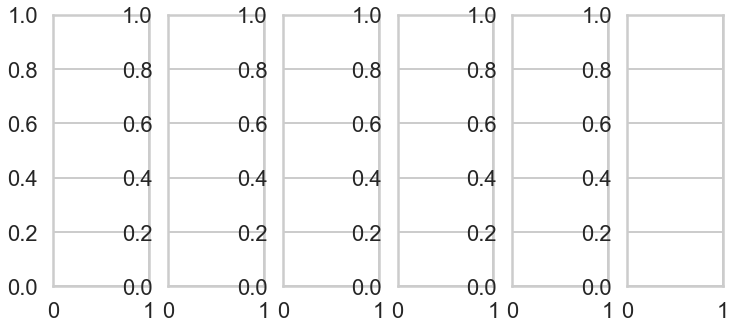

Blank


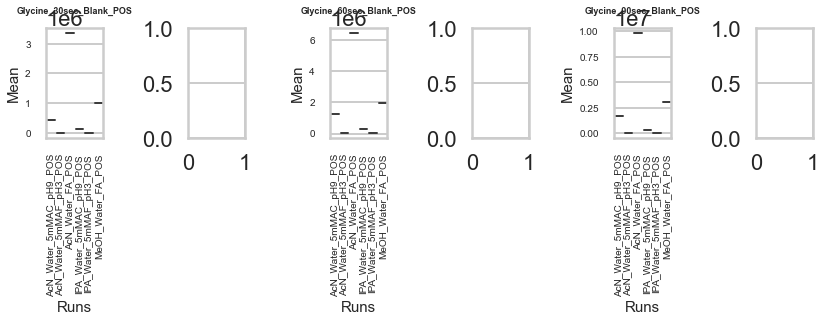

QCSerum


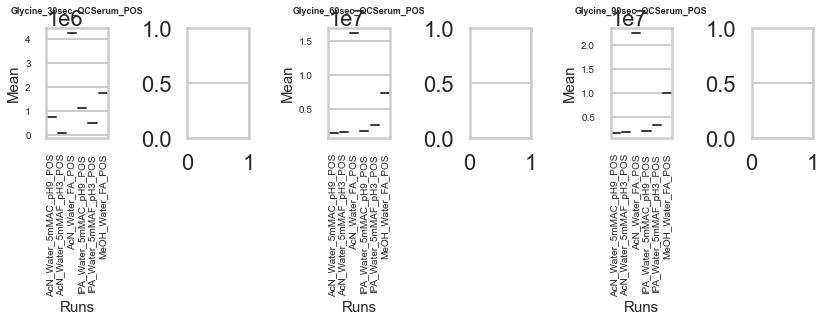

In [69]:
param = 'Mean' #'Rel_Stdv' # 

for index, rows in translator.iterrows():
    metabolite = [rows.DB, rows.Name] 
    file_counter = 0
    for sample_type in sample_types:
        print(sample_type)
        sns.set_context("poster")
        f, axs = plt.subplots(1, len(charges) * 3, figsize=(12, 5), gridspec_kw={'width_ratios': [5] * len(charges) * 3})
        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
        i = 0
        file_name_counter = 0
        for file in stats_files2:
            for charge in charges:
                results_collection = []
                sum_file = pd.concat(file)
                for solvent in solvents:
                    names_collection = []
                    for name in list(sum_file.index):
                        names_collection.append(name[0])
                        run_name = sample_type + '_' + solvent + '_' + charge
                        abbrv_name = solvent + '_' + charge
                        if run_name in names_collection:
                            run_data = copy.deepcopy(sum_file.loc[run_name,:])
                            run_data.loc[:,'Run'] = abbrv_name
                            results_collection.append(run_data)
                results_collection = pd.concat(results_collection)
                ts = [k for k, x in enumerate(results_collection['Metabolite'] == metabolite[0]) if x]
                if len(ts) > 0:
                    results_collection = results_collection.iloc[ts,:]
                    axs[i].set_title((metabolite[1] + '_' + file_names[file_name_counter] + '_' + sample_type + '_' + charge), fontweight="bold", size=9, y=1.08) # Title
                    sns.set_style("whitegrid")
                    sns.violinplot(x="Run", y=param, data=results_collection, orient = 'v', linewidth=2, ax=axs[i],
                                  cmap=cmap)
                    axs[i].tick_params('x', labelrotation=90, labelsize = 10)
                    axs[i].tick_params('y', labelrotation=0, labelsize = 10)
                    axs[i].set_xlabel('Runs', fontsize=15)
                    axs[i].set_ylabel(param, fontsize=15)
                    plt.tight_layout()
                i += 1
            file_name_counter += 1
        plt.show()
        f.savefig('Plots/' + 'SingleMetabolite_' + param + '_' + file_names[file_counter] + '_' + sample_type + '_' + metabolite[1] + '.pdf')
        file_counter += 1